In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F


import torchvision
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import os
from torchsummary import summary



# from google.colab import drive
# drive.mount('/content/drive')
# #Code folder path
# %cd /content/drive/My Drive/ECE591_DL_CL_PROJECT/

#device config
torch.cuda.set_device(1)#Select GPU device 1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Datasets
#Tiny-imagenet: http://cs231n.stanford.edu/tiny-imagenet-200.zip
#Tiny-imagenet-C: https://zenodo.org/records/2469796

#CIFAR-10:  https://www.cs.toronto.edu/~kriz/cifar.html
#CIFAR-10C: https://zenodo.org/records/2535967


In [2]:
# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
        ]
        return test_transforms

transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())#transforms.Compose(
test_transforms = transforms.Compose(transformations.testparams()) #transforms.Compose(

In [3]:
#Download CIFAR-10 Dataset
class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10(self.dirname, train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10(self.dirname, train=False, download=True, transform=test_transforms)

data = GetCIFAR10_TrainData('./Datasets/CIFAR-10')
trainset = data.download_train_data()
testset = data.download_test_data()


trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
#following: https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1) #the blocks we repeat have stride 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [5]:
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):

    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target) #negative log likelihood loss


        train_losses.append(loss.item())
        loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update).

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):

    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified


In [6]:
# Training the model
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0.pt")
        np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0.pt")
np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=1.5486668348312378 Batch_id=97 Accuracy=34.38: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 1.3951, Accuracy: 4918/10000 (49.18%)

EPOCHS : 1


Loss=1.1950790882110596 Batch_id=97 Accuracy=52.37: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 1.1606, Accuracy: 5795/10000 (57.95%)

EPOCHS : 2


Loss=1.0251528024673462 Batch_id=97 Accuracy=60.25: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 1.0232, Accuracy: 6383/10000 (63.83%)

EPOCHS : 3


Loss=0.8448527455329895 Batch_id=97 Accuracy=66.05: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]



Test set: Average loss: 0.8704, Accuracy: 6956/10000 (69.56%)

EPOCHS : 4


Loss=0.8876007795333862 Batch_id=97 Accuracy=68.93: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.7664, Accuracy: 7344/10000 (73.44%)

EPOCHS : 5


Loss=0.7387493848800659 Batch_id=97 Accuracy=71.86: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.8183, Accuracy: 7208/10000 (72.08%)

EPOCHS : 6


Loss=0.68781977891922 Batch_id=97 Accuracy=74.09: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]  



Test set: Average loss: 0.6409, Accuracy: 7814/10000 (78.14%)

EPOCHS : 7


Loss=0.6039744019508362 Batch_id=97 Accuracy=76.20: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.7015, Accuracy: 7622/10000 (76.22%)

EPOCHS : 8


Loss=0.667291522026062 Batch_id=97 Accuracy=77.49: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s] 



Test set: Average loss: 0.6691, Accuracy: 7798/10000 (77.98%)

EPOCHS : 9


Loss=0.5331770777702332 Batch_id=97 Accuracy=78.76: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s] 



Test set: Average loss: 0.5934, Accuracy: 8059/10000 (80.59%)

EPOCHS : 10


Loss=0.6461888551712036 Batch_id=47 Accuracy=80.03:  49%|████▉     | 48/98 [00:11<00:11,  4.18it/s] 


KeyboardInterrupt: 

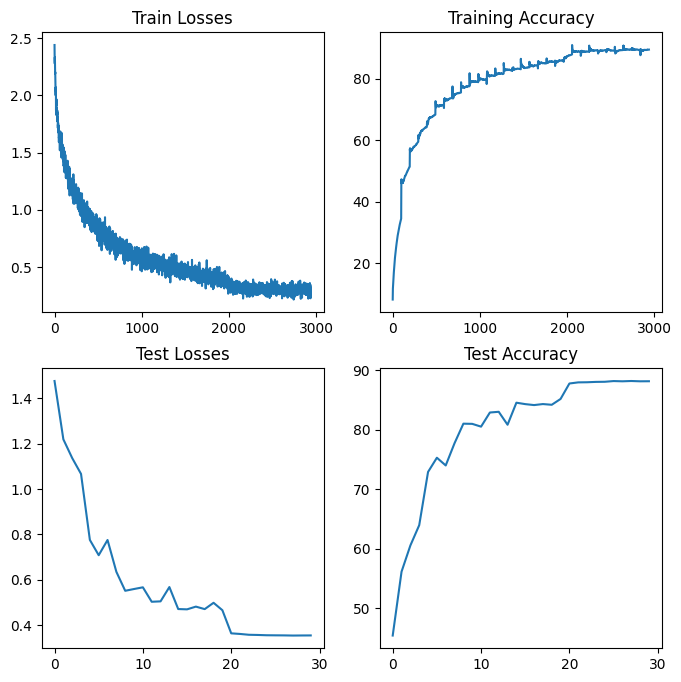

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)